We simulate a star network with three nodes.

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
####################
# Helper Functions #
####################

# treatment assignment rule
def get_treats(pred_out):
    return (pred_out >= 0).astype(np.int8)

# outcome prediction model fitting
def fit_out_pred_model(assign_treats, obs_outs, t, n, K):
    df = pd.DataFrame(data = {
        "treatment": assign_treats.reshape(-1),
        "node_idx": np.tile(np.arange(n), t + 1),
        "outcome": obs_outs.reshape(-1)
    })
    X = df[["treatment", "node_idx"]]
    y = df["outcome"]

    # one-hot encoding categorical variables
    one_hot_encoder = ColumnTransformer(transformers=[
        ("cat", OneHotEncoder(categories=[np.arange(K), np.arange(n)], drop="first"), ["treatment", "node_idx"])], remainder="passthrough")
    X_encoded = one_hot_encoder.fit_transform(X)

    out_pred_model = LinearRegression()
    out_pred_model.fit(X_encoded, y)

    return out_pred_model

# predict the outcomes
def get_pred_out(model, assign_treats, n, K):
    df = pd.DataFrame(data = {
        "treatment": assign_treats,
        "node_idx": np.arange(n)
    })
    X = df[["treatment", "node_idx"]]

    one_hot_encoder = ColumnTransformer(transformers=[
        ("cat", OneHotEncoder(categories=[np.arange(K), np.arange(n)], drop="first"), ["treatment", "node_idx"])], remainder="passthrough")
    X_encoded = one_hot_encoder.fit_transform(X)
    
    return model.predict(X_encoded)


In [4]:
############################
# Parameter Initialization #
############################


### graph parameters ###
# number of nodes
n = 3 

# adjacency matrix for different network structures
G_iso = np.zeros((n, n), dtype=np.int8)
G_star = np.zeros((n, n), dtype=np.int8)
G_star[0, 1:] = G_star[1:, 0] = 1
G_full = np.ones((n, n), dtype=np.int8)
np.fill_diagonal(G_full, 0)

G = G_star

# node degrees
d = np.sum(G, axis=1)

### outcome model parameters ###

# treatment space
treatments = [0, 1]
K = len(treatments)

# model intercept and slopes
alpha = 2       # intercept
beta = 5        # treatment coeff
gamma = 0       # exposure mapping coeff
eta = 2         # confounder coeff

# noise std
noise_std = 1

# confounder mean and std
confd_mean = 0
confd_std = 2

### other parameters ###
# time horizon
T = 100

# history of observed/predicted outcome, assigned treatments, and exposure mapping
obs_outs = np.zeros((T, n))
pred_outs = np.zeros((T, n))
assign_treats = np.zeros((T, n), dtype=np.int8)
obs_confds = np.zeros((T, n))
exp_map = np.zeros((T, n))

In [5]:
###################
# Data Simulation #
###################

# random number generator
rng = np.random.default_rng(123)

### generate initial treatment, confounder, and noise ###
Z_0 = rng.choice(treatments, size = n)
S_0 = rng.normal(confd_mean, confd_std, size = n)
V_0 = G @ Z_0 / d
eps_0 = rng.normal(0, noise_std, size = n)
Y_0 = alpha + beta * Z_0 + gamma * V_0 + eta * S_0 + eps_0
assign_treats[0] = Z_0
exp_map[0] = V_0
obs_outs[0] = Y_0

### initialize outcome prediction model ###
out_pred_model = fit_out_pred_model(Z_0, Y_0, 0, n, K)

for t in range(1, T):

    # predict outcome
    pred_outs[t] = get_pred_out(out_pred_model, assign_treats[t - 1], n, K)

    # generate assigned treatments
    assign_treats[t] = get_treats(pred_outs[t])

    # generate observed confounder 
    obs_confds[t] = rng.normal(confd_mean, confd_std, size = n)

    # compute exposure mapping
    exp_map[t] = G @ assign_treats[t] / d

    # generate random noise
    eps_t = rng.normal(0, noise_std, size = n)

    # compute the observed outcome
    obs_outs[t] = alpha + beta * assign_treats[t] + gamma * exp_map[t] + eta * obs_confds[t] + eps_t

    # refit the outcome prediction model
    out_pred_model = fit_out_pred_model(assign_treats[:(t + 1)], obs_outs[:(t + 1)], t, n, K)

Now we make some plots about the results.

C:\Users\Wenhao\AppData\Local\Temp\ipykernel_25748\1481401901.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Wenhao\AppData\Local\Temp\ipykernel_25748\1481401901.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


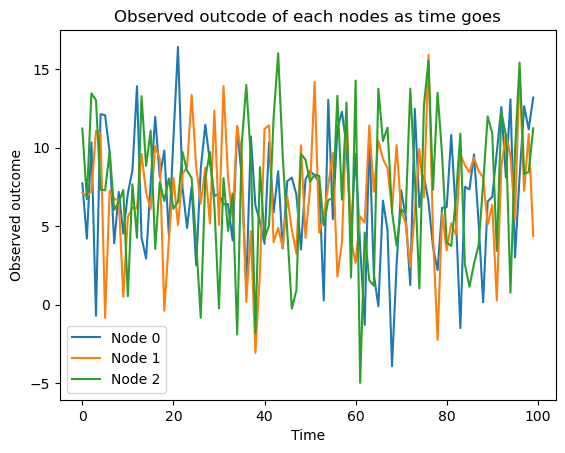

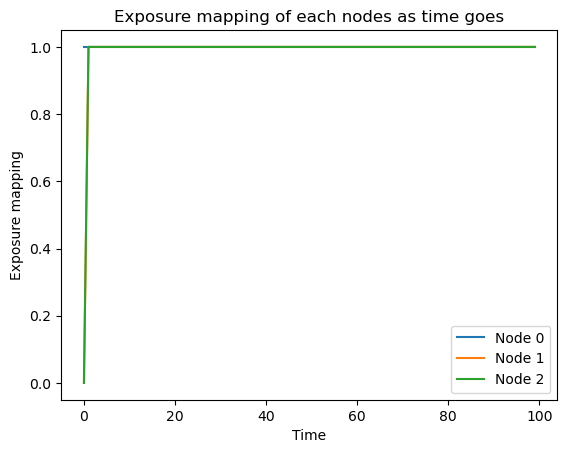

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(n):
    ax.plot(obs_outs[:, i], label = f"Node {i}")
ax.set_xlabel("Time")
ax.set_ylabel("Observed outcome")
ax.set_title("Observed outcode of each nodes as time goes")
ax.legend()
fig.show()

fig, ax = plt.subplots()
for i in range(n):
    ax.plot(exp_map[:, i], label = f"Node {i}")
ax.set_xlabel("Time")
ax.set_ylabel("Exposure mapping")
ax.set_title("Exposure mapping of each nodes as time goes")
ax.legend()
fig.show()